Enter topic to search: potato


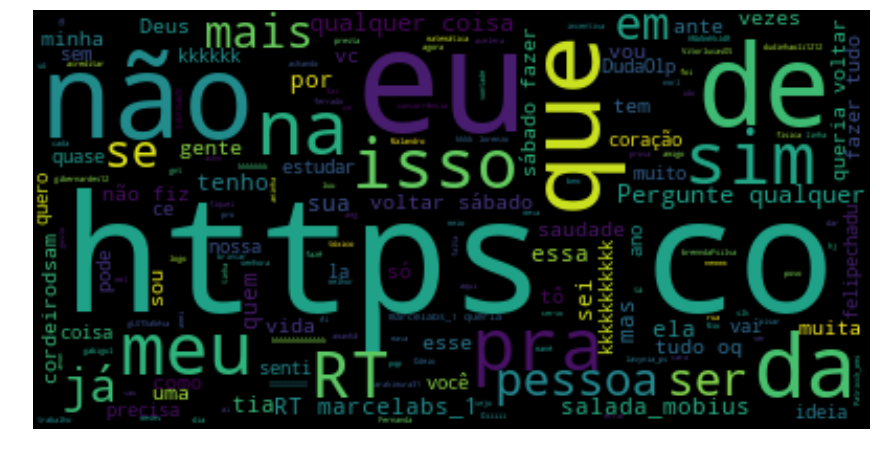

,Sentiment Classification Range,Sentiments,Count
0,0.6 to 1.0,Strong Positive,0
1,0.3 to 0.6,Positive,3
2,0 to 0.3,Weak Positive,2
3,0,Neutral,145
4,-0.3 to 0,Weak Negative,0
5,-0.6 to 0.3,Negative,0
6,-1.0 to -0.6,Strong Negative,0


In [32]:
import tweepy
from tweepy import Stream 
from tweepy import OAuthHandler #for authentication, associated with twitter app
from tweepy.streaming import StreamListener #will listen to tweets 
from tweepy import API
from tweepy import Cursor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re #regular expression
from textblob import TextBlob

#import twitter_credentials

#### Twitter Client ####
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)
        
    def get_twitter_client_api(self):
        return self.twitter_client
    
        self.twitter_user = twitter_user
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id = self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id = self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list
    
    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id = self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets
            

consumer_key = "RIydQiP66Cg0UWDUXaB3AFqbu"
consumer_secret = "F46Sl56eK72JGh6b1FOifWrKkEl9mnRrGvor13aI6XxsZfx59a"

access_key = "92405502-3KOekUgDt9huukhwFBdWP4jWWgwpL0dmCW47Iv6SE"
access_secret = "4HKAif32McyqUl3BzKmyK87wjtdiTj8py3V8TyZPDHt6s"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

#### Twitter Authenticator ####
class TwitterAuthenticator():
    
    def authenticate_twitter_app(self):
        auth = OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_key, access_secret)
        return auth
        

#### Twitter Streamer ####
class TwitterStreamer():
    """
    Class for streaming and processing live tweets
    """
    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()
    
    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        #This handles twitter authentication and the connection to the Twitter Streaming API.
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twitter_app()
        stream = Stream(auth, listener)
    
        #This line filters Twitter Stream to capture data by the keywords:
        stream.filter(track=hash_tag_list)

    
### Twitter Stream Listener
class TwitterListener(StreamListener):
    """
    This is a basic listener class that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename): #__init__ function to handle the authentication of API client
        self.fetched_tweets_filename = fetched_tweets_filename
        
    def on_data(self, data):
        try: 
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BasedException as e:
            print("Error on data: %s" % str(e))
        return True
    
    
    def on_error(self, status):
        if status == 420:
            # Returning false on_data method in case rate limit occurs.
            return False
        print(status)
        
class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets
    """

    def clean_tweet(self, tweet):
        #removesspecial characters from the strings and hyperlinks and returns a clean tweets
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        #Textblob helps to 1) Tokenize 2) Remove stopwords 
        # 3)Do Part of Speech(POS) tagging of tokens to adjective, adverbs
        # 4)Pass the tokens to a sentiment classifier which classifies tweet sentiment as
        # positive/negative/neutral by assigning polarity -1.0 to 1.0 . 
        # Textblob is trained on movie reviews dataset on a Naive Bayes Classifier
        
        return analysis.sentiment.polarity
    
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data = [tweet.text for tweet in tweets], columns=['tweets'])
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        return df
    


search_topic = input("Enter topic to search: ")
if __name__ == "__main__":
    
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()
    api = twitter_client.get_twitter_client_api()
    
#     tweets = api.user_timeline(screen_name = "Fight4HongKong", count  = 2000 )
    tweets = [status for status in tweepy.Cursor(api.search, q="*", geocode = "37.0902,95.7129,250km "
                                                 ).items(150)]

    
    polarity = 0
    positive = 0
    wpositive = 0
    spositive = 0
    negative = 0
    wnegative = 0
    snegative = 0
    neutral = 0

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    for sentiment in df['sentiment']:
        
        if sentiment == 0:
            neutral += 1
        elif (sentiment > 0 and sentiment <= 0.3):
            wpositive += 1
        elif (sentiment > 0.3 and sentiment <= 0.6):
            positive += 1
        elif (sentiment > 0.6 and sentiment <= 1):
            spositive += 1
        elif (sentiment > -0.3 and sentiment <= 0):
            wnegative += 1
        elif (sentiment > -0.6 and sentiment <= -0.3):
            negative += 1
        elif (sentiment > -1 and sentiment <= -0.6):
            snegative += 1


#Dataframe of count of categorized sentiments 
df_sentiments = pd.DataFrame({'Sentiment Classification Range':['0.6 to 1.0', '0.3 to 0.6', '0 to 0.3','0',
                                                                '-0.3 to 0 ', '-0.6 to 0.3', '-1.0 to -0.6'],
                              'Sentiments':['Strong Positive',"Positive","Weak Positive", "Neutral",
                                          "Weak Negative", "Negative", "Strong Negative"],
                                'Count':[spositive, positive, wpositive,
                                            neutral, wnegative, negative, snegative],
                             })


#Pie Chart to show the percentage of Sentiments 
import plotly.graph_objects as go 
labels = ['Strong Positive',"Positive","Weak Positive", "Neutral",
            "Weak Negative", "Negative", "Strong Negative"
         ]
values = [spositive, positive, wpositive,
          neutral, wnegative, negative, snegative
         ]
fig = go.Figure(data = [go.Pie(labels = labels , values = values)])


#Word Cloud for most common words in the given topic
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
all_tweets = ' '.join(tweet for tweet in df['tweets'])
wordcloud = WordCloud(stopwords=STOPWORDS).generate(all_tweets)
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


plt.show()
fig.show()
df_sentiments



{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.5423}